In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylan
import numpy as np

In [22]:
import re

In [23]:
sentences="""Computer programming is the process of telling a computer to do certain things by giving it instructions. 
These instructions are called programs. 
A person who writes instructions is a computer programmer. 
Writing a whole program in machine code would take a long time, so instructions are written in special programming languages that are easier for people to understand. 
The instructions can also be written in an assembly language, which is almost the same as machine code but a little easier to understand."""

In [24]:
sentences=re.sub('[^A-Za-z0-9]+', ' ', sentences)

In [25]:
sentences=re.sub(r'(?:^| )\w(?:$| )',' ', sentences).strip()

In [26]:
sentences=sentences.lower()

In [27]:
words=sentences.split()
vocab=set(words)

In [28]:
vocab_size=len(vocab)
embed_dim=10
context_size=2

In [29]:
word_to_ix={word: i for i, word in enumerate(vocab)}
ix_to_word={i:word for i, word in enumerate(vocab)}

In [30]:
data=[]
for i in range(2, len(words)-2):
    context=[words[i-2], words[i-1], words[i+1], words[i+2]]
    target=words[i]
    data.append((context, target))
print(data[:5])

[(['computer', 'programming', 'the', 'process'], 'is'), (['programming', 'is', 'process', 'of'], 'the'), (['is', 'the', 'of', 'telling'], 'process'), (['the', 'process', 'telling', 'computer'], 'of'), (['process', 'of', 'computer', 'to'], 'telling')]


In [31]:
embeddings=np.random.random_sample((vocab_size, embed_dim))

In [32]:
def linear(m, theta):
    w=theta
    return m.dot(w)

In [33]:
def log_softmax(x):
    e_x=np.exp(x-np.max(x))
    return np.log(e_x/e_x.sum())

In [34]:
def NLLLoss(logs, targets):
    out=logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [46]:
def log_softmax_crossentropy_with_logits(logits, target):
    out=np.zeros_like(logits)
    out[np.arange(len(logits)), target]=1
    softmax=np.exp(logits)/np.exp(logits).sum(axis=-1, keepdims=True)
    return (-out+softmax)/logits.shape[0]

In [47]:
def forward(context_idxs, theta):
    m=embeddings[context_idxs].reshape(1, -1)
    n=linear(m, theta)
    o=log_softmax(n)
    
    return m, n, o

In [48]:
def backward(preds, theta, target_idxs):
    m, n, o=preds
    dlog=log_softmax_crossentropy_with_logits(n, target_idxs)
    dw=m.T.dot(dlog)
    
    return dw

In [49]:
def optimize(theta, grad, lr=0.03):
    theta-=grad*lr
    return theta

In [50]:
theta=np.random.uniform(-1, 1, (2*context_size*embed_dim, vocab_size))

In [51]:
epoch_losses={}
for epoch in range(80):
    losses=[]
    for context, target in data:
        context_idxs=np.array([word_to_ix[w] for w in context])
        preds=forward(context_idxs, theta)
        
        target_idxs=np.array([word_to_ix[target]])
        loss=NLLLoss(preds[-1], target_idxs)
        
        losses.append(loss)
        
        grad=backward(preds, theta, target_idxs)
        theta=optimize(theta, grad, lr=0.03)
        
    epoch_losses[epoch]=losses

Text(0, 0.5, 'Losses')

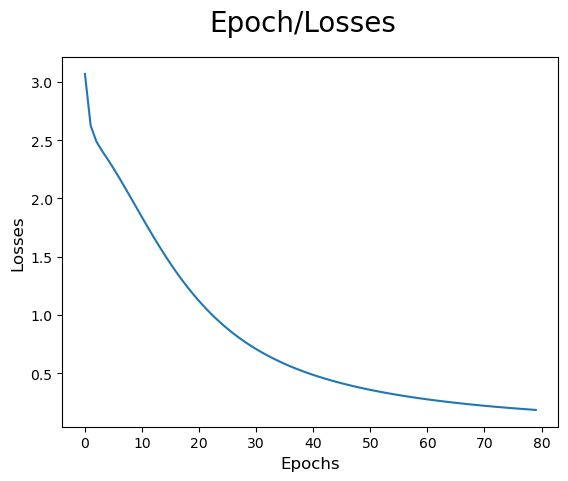

In [52]:
ix=np.arange(0, 80)

fig=plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix, [epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [53]:
def predict(words):
    context_idxs=np.array([word_to_ix[w] for w in words])
    preds=forward(context_idxs, theta)
    word=ix_to_word[np.argmax(preds[-1])]
    
    return word

In [54]:
predict(['instructions', 'these', 'programs', 'called'])

'are'

In [55]:
def accuracy():
    wrong=0
    
    for context, target in data:
        if(predict(context)!=target):
            wrong+=1
            
    return (1-(wrong/len(data)))

In [56]:
accuracy()

1.0